In [1]:
##1
## Importing Modules

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm #just to get the progress bar 
import random
warnings.filterwarnings('ignore')

%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D ,Dropout, Flatten, MaxPooling2D, Input


In [2]:
##2 (CHANGER LA DIRECTORY)
## Load Dataset

BASE_DIR=r"C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset"

In [3]:
##3
#labels: race, gender, ethnicity


image_paths=[]
age_labels=[]
gender_labels=[]


for filename in tqdm(os.listdir(BASE_DIR)): #iterates in all the files inside the direcetory
    image_path=os.path.join(BASE_DIR,filename)
    temp=filename.split('_') #on split le nom de l'image selon les _ pour avoir age , date etc..
    if len(temp) >= 3 and all(p.isdigit() for p in temp[:3]):
        age =int(temp[0])#premier element de la liste
        gender =int(temp[1])#second element de la liste
        image_paths.append(image_path)
        age_labels.append(age)
        gender_labels.append(gender)
    else:
        print(f"Skipping file with unexpected format: {filename}")
    #la barre en bas montre que we loaded all the images 
    

  0%|          | 0/24108 [00:00<?, ?it/s]

Skipping file with unexpected format: 39_1_20170116174525125.jpg
Skipping file with unexpected format: 53__0_20170116184028385.jpg
Skipping file with unexpected format: 61_1_20170109142408075.jpg
Skipping file with unexpected format: 61_3_20170109150557335.jpg


In [4]:
##4
#convert my images into a data frame
df=pd.DataFrame()
df['image_path'],df['age'],df['gender']=image_paths, age_labels, gender_labels # ce sont les colonnes de mon dataframe
df.sample(10) #cette commande nous permet de voir 10 lignes aléatoire, on a creer a proper dataframe


,image_path,age,gender
7951,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,26,1
9685,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,29,0
19472,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,54,1
15860,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,40,0
49,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,10,0
1077,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,17,0
18829,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,52,0
20493,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,5,0
6328,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,26,0
20613,C:\Users\Gabriel\Documents\Inge-2I\UTK_Dataset...,5,1


In [5]:
##5
#define labels of gender
gender_dict={0:'Male',1:'Female'}

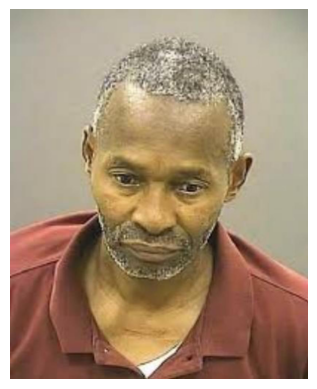

In [6]:
##6
# Exploratory Data Analysis
from PIL import Image  # PIL est un module utilise pour loader des images 
img= Image.open(df['image_path'][random.randint(0, len(df) - 1)]) #on ouvre juste une image aléatoire
plt.axis('off')
plt.imshow(img);
#for better image preproceessing et ne pas surcharge la RAM, La RAM EST LIMITE on utilise grayscale et on la reesize

<AxesSubplot: xlabel='age', ylabel='Density'>

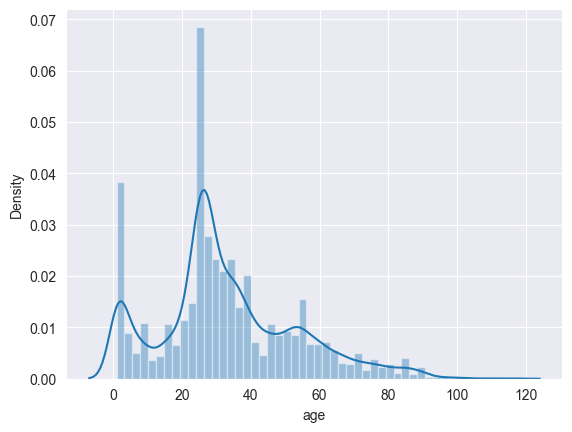

In [7]:
##7
## Class distribution selon l'age

sns.distplot(df['age'])

#On peut utiliser standard scaler ou la normalizaton pour avoir les ages entre 0 et 1 

<AxesSubplot: xlabel='gender', ylabel='count'>

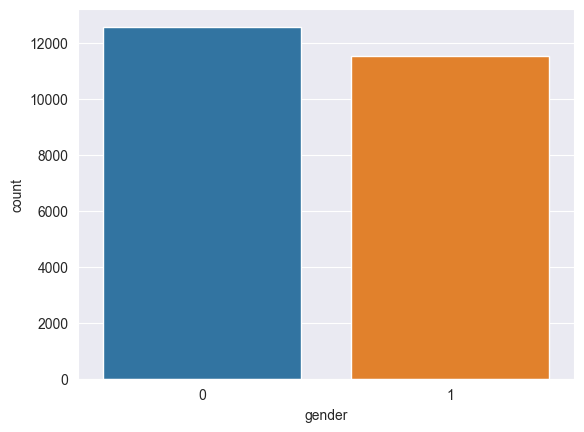

In [8]:
##8
## Class distribution selon le genre
sns.countplot(x= df['gender'], data=df)


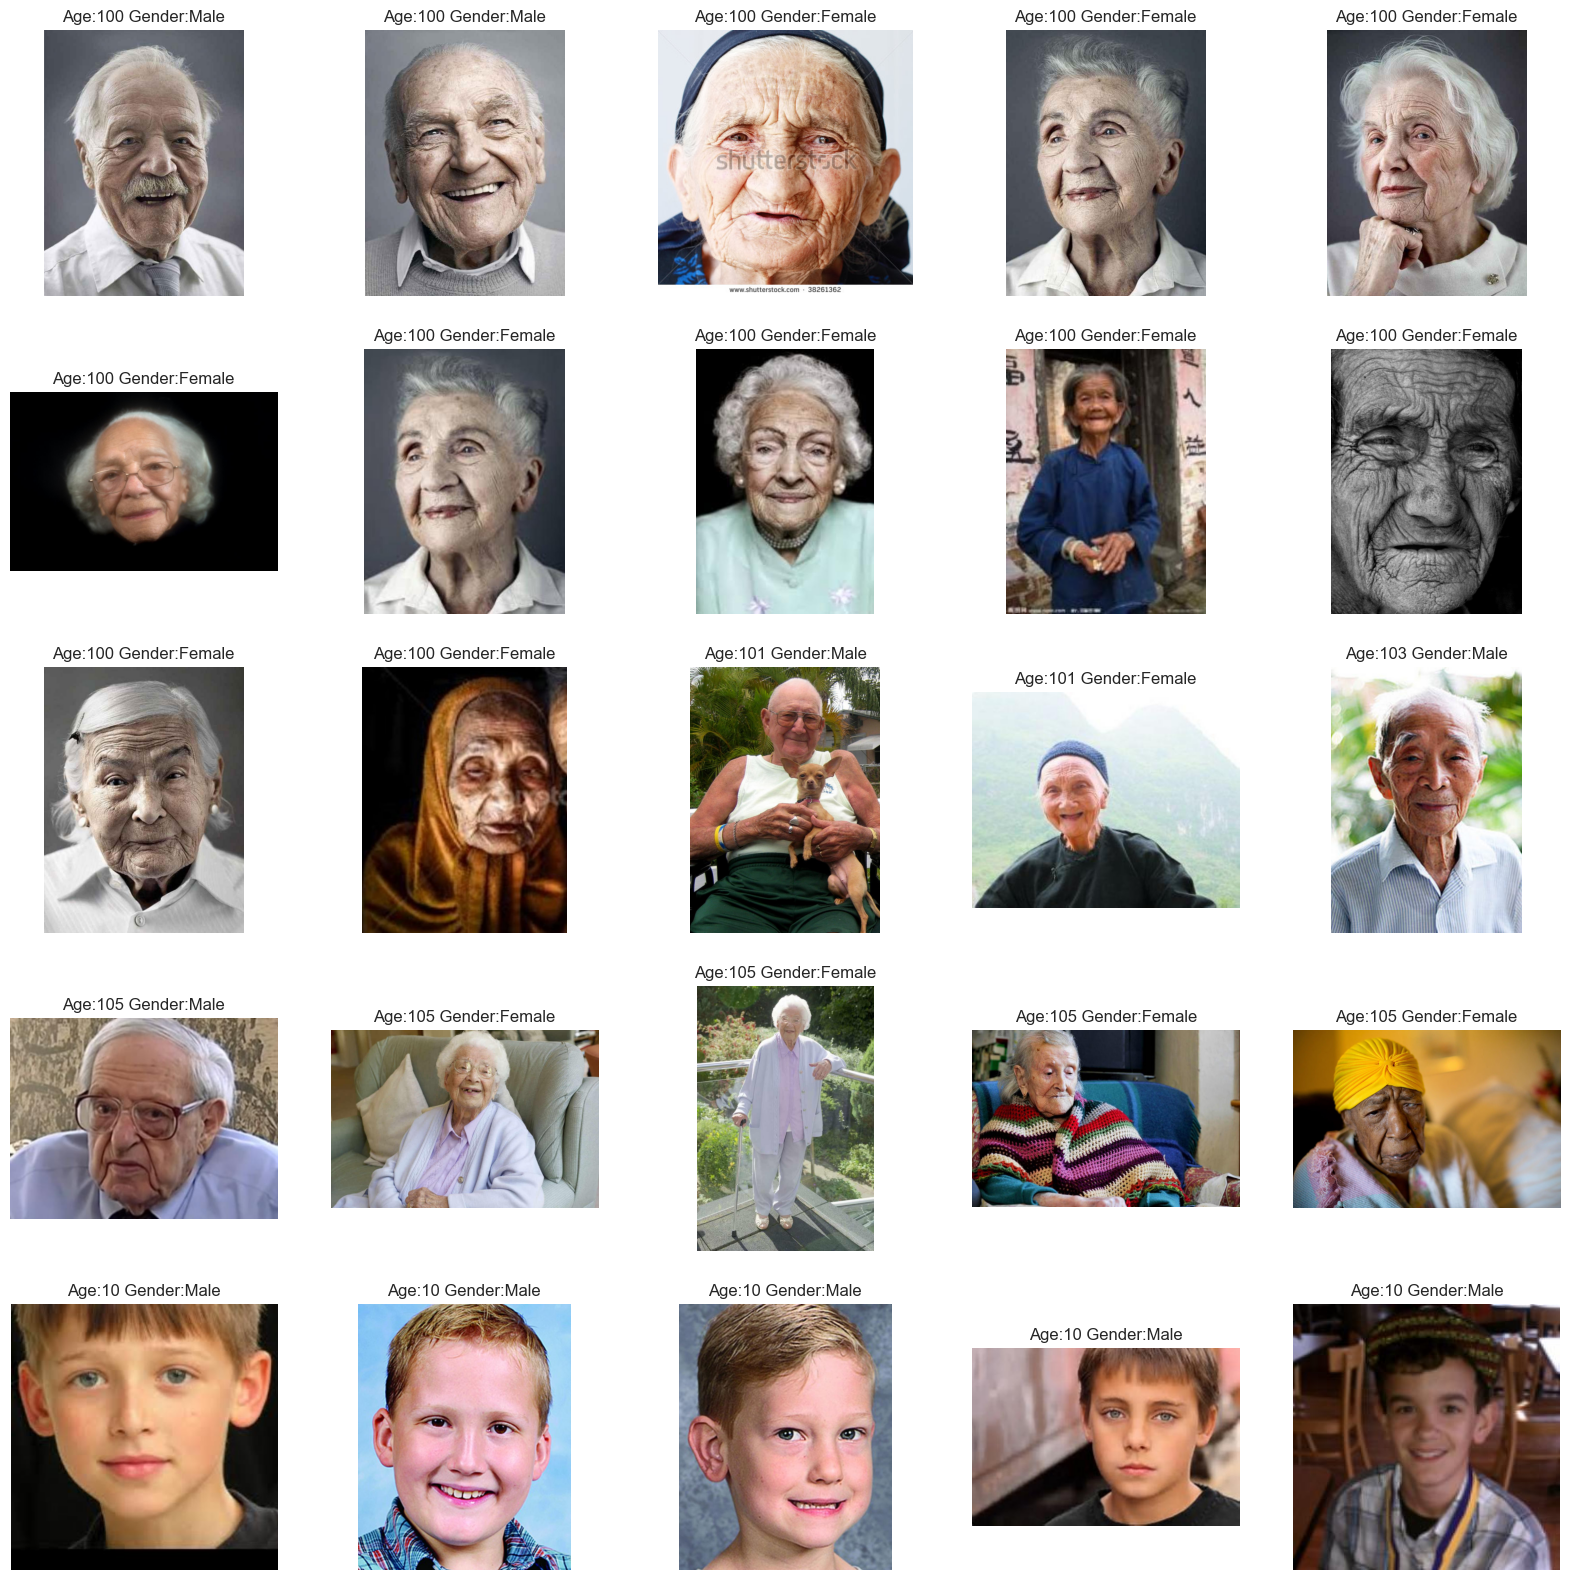

In [9]:
##9
#display a grid of images
plt.figure(figsize=(20,20))
files=df.iloc[0:25]#on prend les 25 premieres images

for index,file,age, gender in files.itertuples(): #we iterate in the file, age and gender columns
    plt.subplot(5,5 ,index+1)
    img=load_img(file)
    img=np.array(img)
    plt.imshow(img)
    plt.title(f"Age:{age} Gender:{gender_dict[gender]}")
    plt.axis('off')



In [10]:
##10
## Extracting features
from keras.preprocessing.image import load_img

def extract_features(images):
    features=[]
    for image in tqdm (images):
         #on ne peux pas  se permettre de load toutes les images en RGB: 3 dimensions  et prendre toute la memoire
        img = load_img(image)
        #img = load_img(image, color_mode='grayscale')
        img=img.resize((128,128),Image.ANTIALIAS)
        img=np.array(img)
        features.append(img)
        
    #we convert the features to a numpy array
    features=np.array(features) # cette etape est obligatoire car les neurals network gere que les array 
    features=features.reshape(len(features),128,128,3) #ca prend en arguments number fo features, width, height et la dimension
    # dans notre cas grayscale image ducoup dimension=1
    #dans le cas ou on sera rester en RGB, on oublie ceci 
    return features 
    
        

In [11]:
##11
X=extract_features(df['image_path'])

  0%|          | 0/24104 [00:00<?, ?it/s]

In [12]:
##12
X.shape
#on verifie bien que la dernier valeur est 1 cad il est en graycale

(24104, 128, 128, 3)

In [13]:
##13
#normalize the images 
X=X/255.0 #la valeur dee la pixel est de 0-255 maintenant  elle sera de la range 0 to 1 

In [14]:
##14
y_gender=np.array(df['gender']) #on convertit to numpy
y_age=np.array(df['age']) #on convertir to numpy 

In [15]:
##15
input_shape=(128,128,3)

In [16]:
##16
## CHARACTERISTIQUE MODEL 1
from keras.applications import VGG16

vgg16 = VGG16(weights=None, include_top=False, input_shape=(128,128,3))
#premier problemee les poids jee n'arrivais pas les rammener
#second probleme VGG16 est fait pour les photos en RGB
# Téléchargement des poids pré-entraînés VGG16
#from keras.utils import get_file
#weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5','https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',cache_subdir='models')
#vgg16.load_weights(weights_path, by_name=True) 

#vous spécifiez que vous voulez utiliser les poids pré-entraînés de ce modèle sur l'ensemble de données ImageNet
#L'utilisation de poids pré-entraînés sur ImageNet pour initialiser votre modèle peut être bénéfique pour plusieurs raisons :ransfert de connaissances (Transfer Learning) 
#Optimisation plus rapide eet Généralisation améliorée 

#vous chargez VGG16 avec include_top=False, cela signifie que vous ne chargez pas la couche 
#de classification finale de VGG16, mais seulement les couches convolutives de base.
# la partie finale qui est spécifique à la classification d'ImageNet. donc il faut l'enlever

for layer in vgg16.layers:
    layer.trainable = False
    
#Cela empêche les poids des couches VGG16 d'être mis à jour pendant l'entraînement.
#Nous voulons conserver les représentations apprises par VGG16 et ne pas les modifier.

x = Flatten()(vgg16.output)#onvertir la sortie de la dernière couche convolutive de VGG16 en un vecteur plat.
x = Dense(256, activation='relu')(x) #ajout de couche personaliser
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(1, activation='linear', name='age_output')(x)

# VGG16

In [ ]:

#CREATION MODEL 1


# Charger les données d'entraînement X et les étiquettes y_gender, y_age

# Assurez-vous que vos données d'entrée sont chargées en niveaux de gris ou en RGB en fonction des besoins du modèle.
# Si vos images sont déjà en niveaux de gris et que votre modèle attend des images RGB, vous devrez les convertir en images RGB.

# Dans cet exemple, supposons que X contient des images en niveaux de gris et que votre modèle attend des images RGB.



# Créer le modèle en spécifiant les entrées et les sorties
model = Model(inputs=vgg16.input, outputs=[gender_output, age_output])
#Nous créons un modèle en spécifiant les entrées (les images) et les sorties (le genre et l'âge) du modèle.

# Compiler le modèle avec les fonctions de perte et les métriques appropriées
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


#La compilation du modèle est l'étape où vous configurez les détails d'apprentissage de votre réseau neuronal.
#Cela comprend le choix de l'optimiseur, des fonctions de perte et des métriques à utiliser pendant l'entraînement

# Entraîner le modèle avec les données d'entraînement
history = model.fit(X, {'gender_output': y_gender, 'age_output': y_age},
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32)



Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 1299s 2s/step - age_output_mae: 18.1021 - gender_output_accuracy: 0.4965 - loss: 499.7132 - val_age_output_mae: 37.2379 - val_gender_output_accuracy: 0.4213 - val_loss: 1555.0137
Epoch 2/10
598/603 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - age_output_mae: 10.9413 - gender_output_accuracy: 0.4907 - loss: 213.0812 

In [ ]:
loss, gender_loss, age_loss, gender_accuracy, age_mae = model.evaluate(X, {'gender_output': y_gender, 'age_output': y_age})
print("Loss:", loss)
print("Gender Loss:", gender_loss)
print("Age Loss:", age_loss)
print("Gender Accuracy:", gender_accuracy)
print("Age MAE:", age_mae)



# MobileNET

In [ ]:
'''
#CREATION MODEL 2

from keras.applications import MobileNet
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger le modèle MobileNet pré-entraîné sans les couches fully connected
base_model = MobileNet(weights=None, include_top=False, input_shape=(128, 128, 3))

# Télécharger les poids pré-entraînés à partir d'une source fiable et les charger localement
#weights_path = '/chemin/vers/les/poids/locaux/mobilenet_1_0_128_tf_no_top.h5'
#base_model.load_weights(weights_path)


# Geler les poids des couches du modèle de base
for layer in base_model.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=base_model.input, outputs=[gender_output, age_output])

# Compiler le modèle
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


'''

# Modele Personelle 

In [ ]:
'''
#CREATION MODEL 3
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy', 'mae'])



# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)
'''

In [ ]:
''''
# Entraîner le modèle
history = model.fit(x=X, y=[y_gender,y_age],epochs=5,batch_size=32,validation_split=0.2)


# Vous pouvez également prédire les sorties pour de nouvelles données
#predictions = model.predict(new_data)
''''

# VGG19

In [ ]:
#CREATION MODEL 4
from keras.applications import VGG19
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

# Charger les données d'entraînement X et les étiquettes y_gender, y_age
# Assurez-vous que vos données sont chargées et prétraitées correctement

# Créer le modèle VGG19 en spécifiant les entrées et les sorties
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Geler les poids des couches du modèle de base
for layer in vgg19.layers:
    layer.trainable = False

# Ajouter des couches fully connected personnalisées au modèle
x = vgg19.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
# Ajouter la sortie pour la prédiction du genre
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
# Ajouter la sortie pour la prédiction de l'âge
age_output = Dense(1, activation='linear', name='age_output')(x)

# Créer le modèle final
model = Model(inputs=vgg19.input, outputs=[gender_output, age_output])

# Compiler le modèle avec les fonctions de perte et les métriques appropriées
model.compile(optimizer='adam',
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mean_squared_error'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})

# Entraîner le modèle avec les données d'entraînement
history = model.fit(X, {'gender_output': y_gender, 'age_output': y_age},
                    validation_split=0.2,
                    epochs=10,
                    batch_size=32)


# Separation modele age et genre 

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense

# Fonction pour créer le modèle d'estimation de l'âge
def create_age_estimation_model(input_shape=(224, 224, 1), num_classes=7):
    inputs = Input(shape=input_shape)
    
    # Couches de convolution et de pooling
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Couche dense pour l'estimation de l'âge
    x = Dense(132, activation='relu')(x)
    age_output = Dense(num_classes, activation='softmax', name='age_output')(x)
    
    model = Model(inputs=inputs, outputs=age_output)
    return model

# Fonction pour créer le modèle de classification du genre
def create_gender_classification_model(input_shape=(64, 64, 3), num_classes=3):
    inputs = Input(shape=input_shape)
    
    # Couches de convolution et de pooling
    x = Conv2D(32, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    
    # Couche dense pour la classification du genre
    x = Dense(132, activation='relu')(x)
    gender_output = Dense(num_classes, activation='softmax', name='gender_output')(x)
    
    model = Model(inputs=inputs, outputs=gender_output)
    return model

# Créer le modèle d'estimation de l'âge
age_model = create_age_estimation_model(input_shape=(224, 224, 1), num_classes=7)

# Créer le modèle de classification du genre
gender_model = create_gender_classification_model(input_shape=(64, 64, 3), num_classes=3)
